<a href="https://colab.research.google.com/github/petersonhaas/corporate-profits-and-GDI/blob/main/Extract_Revisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**Project**: The Impact of Corporate Profits on GDI Estimates: Forecasting and Data Revisions   

####**Objective**: Extract Quarterly Releases (First, Second, Third), Annual Revisions (First, Second, Third), Comprehensive Revision (First), and the Latest Release (Final) of key variables from the National Income and Product Accounts (NIPA), including GDI, GDP, and Corporate Profits.

####**Authors**: Peterson Haas, Dean Croushore (Advisor)  

####**Organization**: University of Richmond  

####**Last Update**: 03/09/2025

# **Initialization**

In [ ]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
import re

# Set Directory
from google.colab import drive
drive.mount('/content/drive')

root_import_original = '/content/drive/MyDrive/Honors Thesis - Peterson Haas/Data/Original Data Files/'
root_import_constructed = '/content/drive/MyDrive/Honors Thesis - Peterson Haas/Data/Constructed Data Files/'
root_save = '/content/drive/MyDrive/Honors Thesis - Peterson Haas/Data/Constructed Data Files/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Datasets**

In [ ]:
# Load Datasets
df_NGDI = pd.read_excel(f'{root_import_constructed}NGDI VINTAGES.xlsx')                       # Nominal GDI
df_NGDP = pd.read_excel(f'{root_import_original}noutputMvQd.xlsx')                            # Nominal GDP
df_RGDP = pd.read_excel(f'{root_import_original}routputMvQd.xlsx')                            # Real GDP
df_deflator = pd.read_excel(f'{root_import_original}pMvQd.xlsx')                              # GDP Deflator (GDP Price Index)
df_NCP = pd.read_excel(f'{root_import_original}ncprofatMvQd.xlsx')                            # Nominal CP
df_NCPW = pd.read_excel(f'{root_import_original}ncprofatwMvQd.xlsx')                          # Nominal CPW
df_annual_rev_dates = pd.read_excel(f'{root_import_constructed}Annual Revision Dates.xlsx')   # Dates with Annual Revisions

# Initialize main dataset
merged_df = []

In [ ]:
# Example (Historic Releases of Nominal GDI)
df_NGDI

,DATE,NGDI66M8,NGDI66M9,NGDI66M10,NGDI66M11,NGDI66M12,NGDI67M1,NGDI67M2,NGDI67M3,NGDI67M4,...,NGDI24M3,NGDI24M4,NGDI24M5,NGDI24M6,NGDI24M7,NGDI24M8,NGDI24M9,NGDI24M10,NGDI24M11,NGDI24M12
0,1947:Q1,223.4,223.4,223.4,223.4,223.4,223.4,223.4,223.4,223.4,...,240.092,240.092,240.092,240.092,240.092,240.092,240.092,240.092,240.092,240.092
1,1947:Q2,225.7,225.7,225.7,225.7,225.7,225.7,225.7,225.7,225.7,...,243.209,243.209,243.209,243.209,243.209,243.209,243.209,243.209,243.209,243.209
2,1947:Q3,229.8,229.8,229.8,229.8,229.8,229.8,229.8,229.8,229.8,...,247.579,247.579,247.579,247.579,247.579,247.579,247.579,247.579,247.579,247.579
3,1947:Q4,239.4,239.4,239.4,239.4,239.4,239.4,239.4,239.4,239.4,...,256.122,256.122,256.122,256.122,256.122,256.122,256.122,256.122,256.122,256.122
4,1948:Q1,248.7,248.7,248.7,248.7,248.7,248.7,248.7,248.7,248.7,...,265.070,265.070,265.070,265.070,265.070,265.070,265.070,265.070,265.070,265.070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2023:Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26945.096,26969.650,26969.650,26969.650,26969.650,26969.650,26969.650,27627.915,27627.915,27627.915
307,2023:Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27402.019,27402.019,27324.039,27324.039,27324.039,27324.039,28082.659,28082.659,28082.659
308,2024:Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27635.102,27623.485,27623.485,27623.485,28499.212,28499.212,28499.212
309,2024:Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27882.454,28920.119,28821.879,28821.879


# **1. Deflate Nominal to Real Values**

In [ ]:
# Define a function to deflate nominal datasets
def deflate_nominal(df_nominal, nominal_prefix, real_prefix):

    """
    Function: Deflate nominal data using corresponding deflators.

    Parameters:
        df_nominal (DataFrame): Nominal dataset.
        nominal_prefix (str): Prefix for nominal columns.
        real_prefix (str): Prefix for real columns.

    Returns:
        DataFrame: Real values computed by deflating nominal data.
    """

    # Select columns other than DATE
    deflator_columns = [col for col in df_deflator.columns if col != "DATE"]
    nominal_columns = [col for col in df_nominal.columns if col != "DATE"]

    # Identify the overlapping columns by extracting the time suffix
    nominal_suffixes = [col.replace(nominal_prefix, "") for col in nominal_columns]
    deflator_suffixes = [col.replace("P", "") for col in deflator_columns]

    # Find the common suffixes between the two datasets
    common_suffixes = [suffix for suffix in nominal_suffixes if suffix in deflator_suffixes]

    # Filter the columns for the common time ranges
    aligned_deflator_columns = [f"P{suffix}" for suffix in common_suffixes]
    aligned_nominal_columns = [f"{nominal_prefix}{suffix}" for suffix in common_suffixes]

    # Initialize the dictionary for real data
    real_data = {"DATE": df_deflator["DATE"]}  # Start with the DATE column

    # Compute real values
    for deflator_col, nominal_col in zip(aligned_deflator_columns, aligned_nominal_columns):
        real_col = deflator_col.replace("P", real_prefix)
        real_data[real_col] = (df_nominal[nominal_col] / df_deflator[deflator_col]) * 100

    return pd.DataFrame(real_data)

In [ ]:
# Deflate Nominal GDI, CPW, CP
df_RGDI = deflate_nominal(df_NGDI, "NGDI", "RGDI")
df_RCP = deflate_nominal(df_NCP, "NCPROFAT", "RCPROFAT")
df_RCPW = deflate_nominal(df_NCPW, "NCPROFATW", "RCPROFATW")

# Save the deflated results
df_RGDI.to_excel(f'{root_save}RGDI VINTAGES.xlsx', index=False)
df_RCP.to_excel(f'{root_save}RCP VINTAGES.xlsx', index=False)
df_RCPW.to_excel(f'{root_save}RCPW VINTAGES.xlsx', index=False)

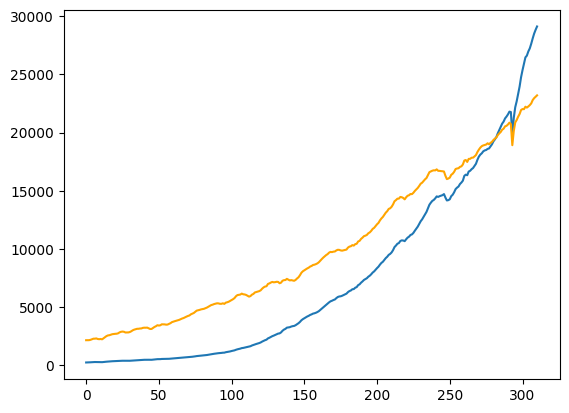

In [ ]:
# Plot (Check if both real and nominal data exist)
ax = df_NGDI.iloc[:, -1].plot()
df_RGDI.iloc[:, -1].plot(ax=ax,color='orange')
plt.show()

# **2. Extract Vintages**

In [ ]:
# Import files

# main files
df_NGDI = pd.read_excel(f'{root_import_constructed}NGDI VINTAGES.xlsx')                      # Nominal GDI (NGDI)
df_RGDI = pd.read_excel(f'{root_import_constructed}RGDI VINTAGES.xlsx')                      # Real GDI (RGDI)

df_NGDP = pd.read_excel(f'{root_import_original}noutputMvQd.xlsx')                           # Nominal GDP (NGDP)
df_RGDP = pd.read_excel(f'{root_import_original}routputMvQd.xlsx')                           # Real GDP (RGDP)

df_NCP = pd.read_excel(f'{root_import_original}ncprofatMvQd.xlsx')                           # Nominal Corporate Profits (NCPROFAT)
df_NCPW = pd.read_excel(f'{root_import_original}ncprofatwMvQd.xlsx')                         # Nominal Corporate Profits With IVA/CCAdj (NCPROFATW)
df_RCP = pd.read_excel(f'{root_import_constructed}RCP VINTAGES.xlsx')                        # Real Corporate Profits (NCPROFAT)
df_RCPW = pd.read_excel(f'{root_import_constructed}RCPW VINTAGES.xlsx')                      # Real Corporate Profits With IVA/CCAdj (NCPROFATW)

df_rec = pd.read_csv(f'{root_import_original}USREC.csv')                                     # US Recessions (Month)

df_deflator = pd.read_excel(f'{root_import_original}pMvQd.xlsx')                             # GDP Deflator (GDP Price Index)


# other NIPAs variables
df_deflator_pce = pd.read_excel(f'{root_import_original}pconQvQd.xlsx')                      # PCE Price Deflator (PCE Price Index)

df_wages = pd.read_excel(f'{root_import_original}wsdQvQd.xlsx')                              # Wages and salaries (WSD - Wage and Salary Disbursements)
df_other_labor = pd.read_excel(f'{root_import_original}oliQvQd.xlsx')                        # Supplements to wages and salaries (OLI – Other Labor Income)

df_proprietors = pd.read_excel(f'{root_import_original}propiQvQd.xlsx')                      # Proprietors’ Income with IVA and CCadj (PROPI – Proprietors' Income)
df_rental = pd.read_excel(f'{root_import_original}rentiQvQd.xlsx')                           # Rental Income of Persons with CCadj (RENTI – Rental Income of Persons)


In [ ]:
def extract_releases(df, name):

    """
    Function: Extract multiple releases (quarterly, annual, comprehensive, final) from a dataset.

    Parameters:
        df (DataFrame): Dataset containing real-time estimates for a given variable.
        name (str): Filename to save the output.

    Returns:
        DataFrame: Extracted releases with their respective quarters.
    """

    # Convert quarter columns to Period[Q] format
    df['DATE'] = df['DATE'].astype(str).str.replace(':Q', 'Q', regex=False)
    df['DATE'] = pd.PeriodIndex(df['DATE'], freq='Q')
    df_annual_rev_dates['Quarter'] = pd.PeriodIndex(df_annual_rev_dates['Quarter'], freq='Q')

    # Extract the first column with the quarters
    quarters = df.iloc[:, 0]

    # Initialize lists for quarterly releases
    first_releases = []
    second_releases = []
    third_releases = []

    # Extract quarterly releases
    for _, row in df.iterrows():
        valid_values = row[1:].dropna().values  # Ensure extraction works even if some are missing
        first_releases.append(valid_values[0] if len(valid_values) > 0 else None)
        second_releases.append(valid_values[1] if len(valid_values) > 1 else None)
        third_releases.append(valid_values[2] if len(valid_values) > 2 else None)

    # Extract final releases
    final_release = df.iloc[:, -1]

    # Extract period columns from revision_dates
    period_columns = df_annual_rev_dates.columns[1:]

    # Extract dataset columns that match the YYM# format
    dataset_columns = {
        re.search(r"(\d{2}M\d{1,2})", str(col)).group(0): col
        for col in df.columns if re.search(r"(\d{2}M\d{1,2})", str(col))
    }

    # Initialize dictionary to store extracted values
    extracted_data = {'Quarter': df_annual_rev_dates.iloc[:, 0]}

    # Loop through each revision column and extract annual and comprehensive estimates from df
    for period in period_columns:
        extracted_data[f'{period} {name}'] = []  # Rename columns dynamically

        for quarter, date in zip(df_annual_rev_dates.iloc[:, 0], df_annual_rev_dates[period]):
            date_str = str(date) if pd.notna(date) else ""  # Ensure valid string conversion

            match = re.search(r"(\d{2}M\d{1,2})", date_str)
            matched_col = dataset_columns.get(match.group(0)) if match else None

            if matched_col and matched_col in df.columns:
                value = df.loc[df.iloc[:, 0] == quarter, matched_col]
                extracted_data[f'{period} {name}'].append(value.values[0] if not value.empty else None)
            else:
                extracted_data[f'{period} {name}'].append(None)

    # Convert to DataFrame
    result_df = pd.DataFrame(extracted_data)

    # Merge annual and comprehensive revisions with final and quarterly estimates previously extracted
    result_df = pd.DataFrame({
        'Quarter': quarters,
        f'Initial {name}': first_releases,
        f'Second {name}': second_releases,
        f'Third {name}': third_releases,
        f'Final {name}': final_release
    }).merge(result_df, on='Quarter', how='left')

    return result_df.to_excel(f'{root_save}{name}_releases.xlsx', index=False)

In [ ]:
# df_rec: convert quarter columns to Period[Q] format and set as index
df_rec['DATE'] = pd.PeriodIndex(df_rec['DATE'], freq='Q')
df_rec['Quarter'] = df_rec['DATE']
df_rec['Quarter'] = df_rec['Quarter'].drop_duplicates()
df_rec.drop(columns='DATE', inplace=True)

In [ ]:
# List of datasets with corresponding labels
datasets = [
    (df_NGDI, 'NGDI'),
    (df_NGDP, 'NGDP'),
    (df_NCP, 'NCP'),
    (df_NCPW, 'NCPW'),

    (df_RGDI, 'RGDI'),
    (df_RGDP, 'RGDP'),
    (df_RCP, 'RCP'),
    (df_RCPW, 'RCPW'),

    (df_deflator, 'DEFLATOR'),
    (df_wages, 'WAGES'),
    (df_other_labor, 'OTHER_LABOR'),
    (df_proprietors, 'PROPRIETORS'),
    (df_rental, 'RENTAL')
]

# Extract releases for each dataset
for df, label in datasets:
  extract_releases(df,label)

# Load datasets from saved files dynamically
dataframes = [pd.read_excel(f'{root_save}{label}_releases.xlsx') for _, label in datasets]


# Merge all datasets on 'Quarter' column
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Quarter', how='outer'), dataframes)

# Convert 'Quarter' column to Period[Q] format and set as index
merged_df['Quarter'] = pd.PeriodIndex(merged_df['Quarter'].str.replace(':Q', 'Q', regex=False), freq='Q')

# Merge with df_rec
merged_df = pd.merge(merged_df, df_rec, on='Quarter', how='inner')

# Save the new DataFrame to an Excel file
merged_df.to_excel(f'{root_save}merged_releases.xlsx', index=False)
merged_df

,Quarter,Initial NGDI,Second NGDI,Third NGDI,Final NGDI,A1 NGDI,A2 NGDI,A3 NGDI,C1 NGDI,Initial NGDP,...,C1 PROPRIETORS,Initial RENTAL,Second RENTAL,Third RENTAL,Final RENTAL,A1 RENTAL,A2 RENTAL,A3 RENTAL,C1 RENTAL,USREC
0,1946Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1946Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1946Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1946Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1947Q1,223.400,223.400,223.400,240.092,NaN,NaN,NaN,NaN,223.6,...,NaN,7.0,7.0,7.0,6.7,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2023Q3,26956.460,26945.096,26945.096,27627.915,27627.915,NaN,NaN,NaN,27623.5,...,NaN,974.5,974.4,974.4,995.0,NaN,NaN,NaN,NaN,0
311,2023Q4,27402.019,27402.019,27324.039,28082.659,28082.659,NaN,NaN,NaN,27938.8,...,NaN,986.9,988.1,988.1,1013.6,NaN,NaN,NaN,NaN,0
312,2024Q1,27635.102,27623.485,27623.485,28499.212,NaN,NaN,NaN,NaN,28284.5,...,NaN,1024.5,1023.9,1046.1,1046.1,NaN,NaN,NaN,NaN,0
313,2024Q2,27882.454,28920.119,28821.879,28821.879,NaN,NaN,NaN,NaN,28629.2,...,NaN,1026.3,1053.4,NaN,1053.4,NaN,NaN,NaN,NaN,0


# **3. Calculations**

In [ ]:
# GROWTH RATES: Compute SAAR growth rates for each column using a 4-quarter lag.

# Build a dictionary of growth rate columns
growth_rates = {}

for col in merged_df.columns:
    if col != 'Quarter':
        growth_rates[f'g{col}'] = (merged_df[col] / merged_df[col].shift(4) - 1) * 100

# Add all growth rate columns to the DataFrame at once (avoids fragmentation)
merged_df = pd.concat([merged_df, pd.DataFrame(growth_rates)], axis=1)

merged_df

,Quarter,Initial NGDI,Second NGDI,Third NGDI,Final NGDI,A1 NGDI,A2 NGDI,A3 NGDI,C1 NGDI,Initial NGDP,...,gC1 PROPRIETORS,gInitial RENTAL,gSecond RENTAL,gThird RENTAL,gFinal RENTAL,gA1 RENTAL,gA2 RENTAL,gA3 RENTAL,gC1 RENTAL,gUSREC
0,1946Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1946Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1946Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1946Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1947Q1,223.400,223.400,223.400,240.092,NaN,NaN,NaN,NaN,223.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2023Q3,26956.460,26945.096,26945.096,27627.915,27627.915,NaN,NaN,NaN,27623.5,...,NaN,22.655758,22.581457,22.581457,11.860596,NaN,NaN,NaN,NaN,NaN
311,2023Q4,27402.019,27402.019,27324.039,28082.659,28082.659,NaN,NaN,NaN,27938.8,...,NaN,22.095757,21.717172,21.717172,10.281797,NaN,NaN,NaN,NaN,NaN
312,2024Q1,27635.102,27623.485,27623.485,28499.212,NaN,NaN,NaN,NaN,28284.5,...,NaN,21.717952,21.171598,10.604779,8.561644,NaN,NaN,NaN,NaN,NaN
313,2024Q2,27882.454,28920.119,28821.879,28821.879,NaN,NaN,NaN,NaN,28629.2,...,NaN,18.784722,9.603579,NaN,7.041967,NaN,NaN,NaN,NaN,NaN


In [ ]:
# EARLIER VINTAGE AS A SHARE OF FINAL VINTAGE

for dataset, name in datasets:
    # Define all possible release stages with their corresponding column names
    comparisons = {
        'i': 'Initial',
        '2': 'Second',
        '3': 'Third',
        'a1': 'A1',
        'a2': 'A2',
        'a3': 'A3',
        'c1': 'C1'
    }

    # Dictionary of new columns
    new_columns = {}

    # Calculate share of earlier estimate relative to final release
    for target, target_col in comparisons.items():

        # LEVELS: (Target Release / Initial Release) * 100
        new_columns[f'Share {target}:f {name}'] = (merged_df[f'{target_col} {name}'] / merged_df[f'Final {name}'] * 100)

    # Combine all new columns into the DataFrame at once (avoids fragmentation)
    merged_df = pd.concat([merged_df, pd.DataFrame(new_columns)], axis=1)
merged_df

,Quarter,Initial NGDI,Second NGDI,Third NGDI,Final NGDI,A1 NGDI,A2 NGDI,A3 NGDI,C1 NGDI,Initial NGDP,...,Share a2:f PROPRIETORS,Share a3:f PROPRIETORS,Share c1:f PROPRIETORS,Share i:f RENTAL,Share 2:f RENTAL,Share 3:f RENTAL,Share a1:f RENTAL,Share a2:f RENTAL,Share a3:f RENTAL,Share c1:f RENTAL
0,1946Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1946Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1946Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1946Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1947Q1,223.400,223.400,223.400,240.092,NaN,NaN,NaN,NaN,223.6,...,NaN,NaN,NaN,104.477612,104.477612,104.477612,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2023Q3,26956.460,26945.096,26945.096,27627.915,27627.915,NaN,NaN,NaN,27623.5,...,NaN,NaN,NaN,97.939698,97.929648,97.929648,NaN,NaN,NaN,NaN
311,2023Q4,27402.019,27402.019,27324.039,28082.659,28082.659,NaN,NaN,NaN,27938.8,...,NaN,NaN,NaN,97.365825,97.484215,97.484215,NaN,NaN,NaN,NaN
312,2024Q1,27635.102,27623.485,27623.485,28499.212,NaN,NaN,NaN,NaN,28284.5,...,NaN,NaN,NaN,97.935188,97.877832,100.000000,NaN,NaN,NaN,NaN
313,2024Q2,27882.454,28920.119,28821.879,28821.879,NaN,NaN,NaN,NaN,28629.2,...,NaN,NaN,NaN,97.427378,100.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
# REVISIONS TO LEVELS AND GROWTH RATES
      # REVISIONS TO LEVELS: Compute change in levels between different vintages, as a percentage of the earlier release:
      # REVISIONS TO GROWTH RATES: Compute change in growth rates between different vintages

      # second (2), third (3), final (f), first annual (a1), second annual (a2), third annual (a3), first comprehensive (c1)

for dataset, name in datasets:
    # Define all possible release stages with their corresponding column names
    comparisons = {
        'i': 'Initial',
        '2': 'Second',
        '3': 'Third',
        'a1': 'A1',
        'a2': 'A2',
        'a3': 'A3',
        'c1': 'C1',
        'f': 'Final'
    }

    # Initialize dictionaries to store revisions
    level_revisions = {}
    growth_revisions = {}

    # Loop through each pair of releases to calculate percentage revisions
    for base, base_col in comparisons.items():
        for target, target_col in comparisons.items():
            # Skip if comparing the same release (e.g., Initial vs Initial)
            if base == target:
                continue

            # Calculate the percentage revision:

            # REVISIONS TO LEVELS: ((target release / base release) - 1) * 100  --> Example: ((A1 / A2) - 1) * 100
            level_revisions[f'Rev {target}:{base} {name}'] = (
                (merged_df[f'{target_col} {name}'] / merged_df[f'{base_col} {name}'] - 1) * 100)

            # REVISIONS TO GROWTH RATES: (target release - base release)  --> Example: (A3 - A2)
            growth_revisions[f'gRev {target}:{base} {name}'] = (
                merged_df[f'g{target_col} {name}'] - merged_df[f'g{base_col} {name}'])

    # Add all new columns at once to avoid fragmentation
    merged_df = pd.concat([merged_df, pd.DataFrame(level_revisions)], axis=1)
    merged_df = pd.concat([merged_df, pd.DataFrame(growth_revisions)], axis=1)

merged_df

,Quarter,Initial NGDI,Second NGDI,Third NGDI,Final NGDI,A1 NGDI,A2 NGDI,A3 NGDI,C1 NGDI,Initial NGDP,...,gRev a2:c1 RENTAL,gRev a3:c1 RENTAL,gRev f:c1 RENTAL,gRev i:f RENTAL,gRev 2:f RENTAL,gRev 3:f RENTAL,gRev a1:f RENTAL,gRev a2:f RENTAL,gRev a3:f RENTAL,gRev c1:f RENTAL
0,1946Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1946Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1946Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1946Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1947Q1,223.400,223.400,223.400,240.092,NaN,NaN,NaN,NaN,223.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2023Q3,26956.460,26945.096,26945.096,27627.915,27627.915,NaN,NaN,NaN,27623.5,...,NaN,NaN,NaN,10.795162,10.720861,10.720861,NaN,NaN,NaN,NaN
311,2023Q4,27402.019,27402.019,27324.039,28082.659,28082.659,NaN,NaN,NaN,27938.8,...,NaN,NaN,NaN,11.813959,11.435374,11.435374,NaN,NaN,NaN,NaN
312,2024Q1,27635.102,27623.485,27623.485,28499.212,NaN,NaN,NaN,NaN,28284.5,...,NaN,NaN,NaN,13.156308,12.609954,2.043135,NaN,NaN,NaN,NaN
313,2024Q2,27882.454,28920.119,28821.879,28821.879,NaN,NaN,NaN,NaN,28629.2,...,NaN,NaN,NaN,11.742755,2.561612,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Verify list of columns
# merged_df.columns.tolist()

In [ ]:
# Filter data to include only records from Q1 1966 and beyond
merged_df = merged_df[merged_df["Quarter"] >= "1966Q1"]


# CORPORATE PROFITS AS SHARE OF GDI

# Prefixes to loop through
prefixes = ['Initial', 'Second', 'Third', 'A1', 'A2', 'A3', 'C1', 'Final']

# Initialize dictionaries to store CP and CPW share columns
rcp_share_columns = {}
ncp_share_columns = {}
rcpw_share_columns = {}
ncpw_share_columns = {}

for prefix in prefixes:
    # Create CP as share of GDI columns and store in the dictionary
    rcp_share_columns[f'{prefix} RCP share'] = (merged_df[f'{prefix} RCP'] / merged_df[f'{prefix} RGDI']) * 100
    ncp_share_columns[f'{prefix} NCP share'] = (merged_df[f'{prefix} NCP'] / merged_df[f'{prefix} NGDI']) * 100

    # Create CPW as share of GDI columns and store in the dictionary
    rcpw_share_columns[f'{prefix} RCPW share'] = (merged_df[f'{prefix} RCPW'] / merged_df[f'{prefix} RGDI']) * 100
    ncpw_share_columns[f'{prefix} NCPW share'] = (merged_df[f'{prefix} NCPW'] / merged_df[f'{prefix} NGDI']) * 100

# Add all share columns to the dataframe
merged_df = pd.concat([merged_df, pd.DataFrame(rcp_share_columns)], axis=1)
merged_df = pd.concat([merged_df, pd.DataFrame(ncp_share_columns)], axis=1)
merged_df = pd.concat([merged_df, pd.DataFrame(rcpw_share_columns)], axis=1)
merged_df = pd.concat([merged_df, pd.DataFrame(ncpw_share_columns)], axis=1)

# Save
merged_df.to_excel(f'{root_save}merged_releases.xlsx', index=False)
merged_df.to_csv(f'{root_save}merged_releases.csv', index=False)

merged_df

,Quarter,Initial NGDI,Second NGDI,Third NGDI,Final NGDI,A1 NGDI,A2 NGDI,A3 NGDI,C1 NGDI,Initial NGDP,...,C1 RCPW share,Final RCPW share,Initial NCPW share,Second NCPW share,Third NCPW share,A1 NCPW share,A2 NCPW share,A3 NCPW share,C1 NCPW share,Final NCPW share
80,1966Q1,717.600,717.600,717.600,789.329,722.900,726.3,726.0,725.8,714.1,...,NaN,7.284668,7.316054,7.316054,7.316054,NaN,NaN,NaN,NaN,8.196836
81,1966Q2,729.000,728.800,728.800,801.086,734.700,740.1,740.2,739.3,732.0,...,NaN,7.340036,7.023320,7.025247,7.025247,NaN,NaN,NaN,NaN,7.951706
82,1966Q3,740.600,740.400,740.300,814.396,747.900,753.6,754.1,752.3,746.0,...,NaN,7.306028,6.751283,6.753106,6.754019,NaN,NaN,NaN,NaN,7.698957
83,1966Q4,755.800,755.600,755.600,828.503,761.500,766.9,766.8,765.0,759.1,...,NaN,7.519587,6.893358,6.895183,6.895183,NaN,NaN,NaN,NaN,7.785126
84,1967Q1,761.500,762.100,766.200,836.797,770.900,771.3,770.7,771.1,764.3,...,NaN,7.731863,6.513460,6.508332,6.473506,NaN,NaN,NaN,NaN,7.492857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2023Q3,26956.460,26945.096,26945.096,27627.915,27627.915,NaN,NaN,NaN,27623.5,...,NaN,10.300090,10.049168,10.012583,10.012583,10.688465,NaN,NaN,NaN,10.688465
311,2023Q4,27402.019,27402.019,27324.039,28082.659,28082.659,NaN,NaN,NaN,27938.8,...,NaN,10.005819,10.229903,10.229903,10.259098,11.045250,NaN,NaN,NaN,11.045250
312,2024Q1,27635.102,27623.485,27623.485,28499.212,NaN,NaN,NaN,NaN,28284.5,...,NaN,9.813605,9.967396,9.871311,9.871311,NaN,NaN,NaN,NaN,10.655382
313,2024Q2,27882.454,28920.119,28821.879,28821.879,NaN,NaN,NaN,NaN,28629.2,...,NaN,9.838012,9.948909,10.863026,10.900053,NaN,NaN,NaN,NaN,10.900053
